The task at hand is to optimize marketing expenses for the Yandex.Afisha product.

## Open data files, study tables and optimize where possible

In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

In [2]:
# Import visit logs data, converting category type and datetime types
visit_logs = pd.read_csv('/datasets/visits_log_us.csv', dtype={'Device':'category'},parse_dates=['Start Ts','End Ts'])
print(visit_logs.info())
print(visit_logs.describe())

# Import order logs data, converting datetime types
order_logs = pd.read_csv('/datasets/orders_log_us.csv',parse_dates=['Buy Ts'])
print(order_logs.info())
print(order_logs.describe())

# Import costs data, converting datetime types
cost = pd.read_csv('/datasets/costs_us.csv',parse_dates=['dt'])
print(cost.info())
print(cost.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
Device       359400 non-null category
End Ts       359400 non-null datetime64[ns]
Source Id    359400 non-null int64
Start Ts     359400 non-null datetime64[ns]
Uid          359400 non-null uint64
dtypes: category(1), datetime64[ns](2), int64(1), uint64(1)
memory usage: 11.3 MB
None
           Source Id           Uid
count  359400.000000  3.594000e+05
mean        3.750515  9.202557e+18
std         1.917116  5.298433e+18
min         1.000000  1.186350e+13
25%         3.000000  4.613407e+18
50%         4.000000  9.227413e+18
75%         5.000000  1.372824e+19
max        10.000000  1.844668e+19
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
Buy Ts     50415 non-null datetime64[ns]
Revenue    50415 non-null float64
Uid        50415 non-null uint64
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB
None


Store the data on visits, orders, and expenses in variables and optimize variable types. The visit_logs table contains columns device, end ts, start ts, source id and uid. The order_logs table contains colums buy ts, revenue and uid. The cost table contains columns source id, dt, cost.

## Data Preprocessing

In [3]:
# Modify visit_logs column names
visit_logs = visit_logs.rename(columns={"Device": "device_type", "End Ts":"session_end", "Start Ts":"session_start", "Source Id":"source_id","Uid":"user_id"})

# Drop duplicates
visit_logs = visit_logs.drop_duplicates().reset_index(drop=True)

display(visit_logs.head())

# Modify order_logs column names
order_logs = order_logs.rename(columns={"Buy Ts":"order_datetime", "Revenue":"revenue","Uid":"user_id"})

# Drop duplicates
order_logs = order_logs.drop_duplicates().reset_index(drop=True)

display(order_logs.head())

# Modify cost column names
cost = cost.rename(columns={"dt":"ad_datetime","costs":"ad_expenses"})

# Drop duplicates
cost = cost.drop_duplicates().reset_index(drop=True)

display(cost.head())


,device_type,session_end,source_id,session_start,user_id
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168


,order_datetime,revenue,user_id
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450


,source_id,ad_datetime,ad_expenses
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08


Modify and preprocess all tables by modifying column anmes to be more intuitive and drop any duplicates.

### Remove outliers

In [4]:
# # Drop rows where session_start = session_end 
# outlierIndex = visit_logs[(visit_logs['session_start'] == visit_logs['session_end'])].index
# visit_logs.drop(outlierIndex, inplace=True)
# display(visit_logs)

# # Drop outliers in order_logs DF where revenue is -2sigma <= and >= 2sigma 
# ad_expenses_mean, ad_expenses_std = order_logs['revenue'].mean(), order_logs['revenue'].std()
# cut_off = ad_expenses_std #*2
# outlierIndex = order_logs[(order_logs['revenue'] <= ad_expenses_mean + cut_off) &  (ad_expenses_mean - cut_off <= order_logs['revenue'])].index
# order_logs.drop(outlierIndex, inplace=True)
# display(order_logs)

# # Drop outliers in cost DF where the ad_expenses is -2sigma <= and >= 2sigma 
# ad_expenses_mean, ad_expenses_std = cost['ad_expenses'].mean(), cost['ad_expenses'].std()
# cut_off = ad_expenses_std #*2
# outlierIndex = cost[(cost['ad_expenses'] <= ad_expenses_mean + cut_off) &  (ad_expenses_mean - cut_off <= cost['ad_expenses'])].index
# cost.drop(outlierIndex, inplace=True)
# display(cost)

Remove any and all outliers where: session start datetime is the same as session end datetime, the revenue is out of the +/- 2 sigma range and the ad costs is out of the +/- 2 sigma range. 

## Product evaluation of Yandex.Afisha

### How many people use it every day, week and month?

In [5]:
# How many people use it every day, week and month?

# Create product usage from visit logs table
product_usage = visit_logs.copy()

# Separate columsn for day, week, month values
product_usage['session_date'] = product_usage['session_start'].dt.date
product_usage['session_week'] = product_usage['session_start'].dt.week
product_usage['session_month'] = product_usage['session_start'].dt.month
product_usage['session_year'] = product_usage['session_start'].dt.year

# Calculate DAU: number of daily active unique users
dau_total = product_usage.groupby('session_date').agg({"user_id":"nunique"}).reset_index()
dau_total.columns = ['session_date', 'n_users']
dau_avg = dau_total['n_users'].mean()
print("Daily Total Usage: " + str((dau_avg.round(decimals=2))) + " users")

# Calculate WAU: number of weekly active unique users
wau_total = product_usage.groupby('session_week').agg({"user_id":"nunique"}).reset_index()
wau_total.columns = ['session_week', 'n_users']
wau_avg = wau_total['n_users'].mean()
print("Weekly Total Usage: " + str((wau_avg.round(decimals=2))) + " users")

# Calculate DAU: number of monthly active unique users
mau_total = product_usage.groupby('session_month').agg({"user_id":"nunique"}).reset_index()
mau_total.columns = ['session_month', 'n_users']
mau_avg = mau_total['n_users'].mean()
print("Monthly Total Usage: " + str((mau_avg.round(decimals=2))) + " users")

Daily Total Usage: 907.99 users
Weekly Total Usage: 5825.29 users
Monthly Total Usage: 23228.42 users


Text(0, 0.5, '# of Active Users')

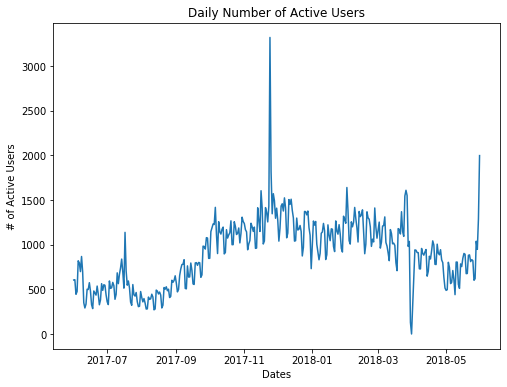

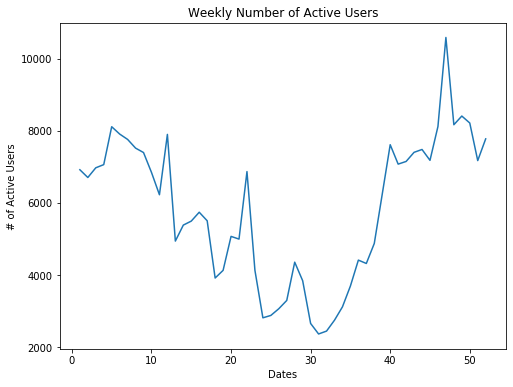

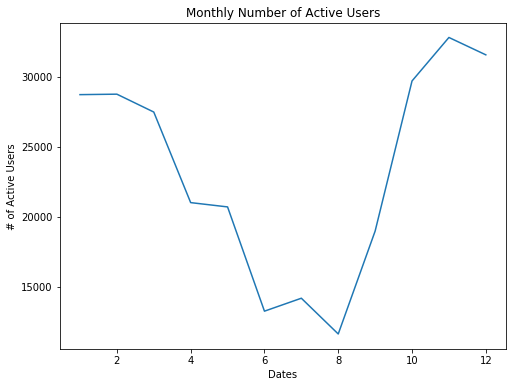

In [6]:
# plot daily active users
plt.figure(figsize=(8,6))
plt.plot(dau_total['session_date'],dau_total['n_users'])
plt.title('Daily Number of Active Users')
plt.xlabel('Dates')
plt.ylabel('# of Active Users')

# plot weekly active users
plt.figure(figsize=(8,6))
plt.plot(wau_total['session_week'],wau_total['n_users'])
plt.title('Weekly Number of Active Users')
plt.xlabel('Dates')
plt.ylabel('# of Active Users')

# plot monthly active users
plt.figure(figsize=(8,6))
plt.plot(mau_total['session_month'],mau_total['n_users'])
plt.title('Monthly Number of Active Users')
plt.xlabel('Dates')
plt.ylabel('# of Active Users')


### How many sessions are there per day? 

There are 987.36 sessions per day


Text(0, 0.5, '# of Sessions')

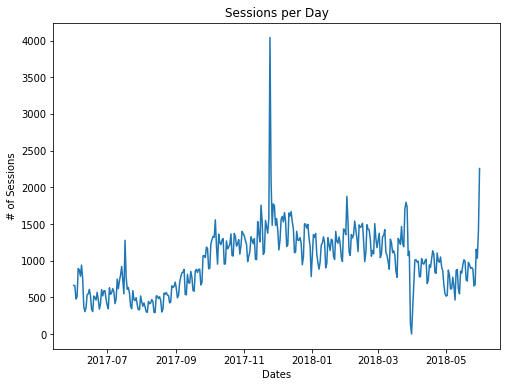

In [7]:
# How many sessions are there per day? (One user might have more than one session.)

# group the visit data by session date and then count the # of unqiue users and # of unique sessions
sessions_per_day = product_usage.groupby('session_date').agg({'user_id':['count','nunique']}).reset_index()
sessions_per_day.columns = ['session_date','n_sessions','n_users']
sessions_per_day_amount = sessions_per_day['n_sessions'].mean()
print('There are ' + str(sessions_per_day_amount.round(decimals=2)) + " sessions per day")

#  Plot sessions per day
plt.figure(figsize=(8,6))
plt.plot(pd.to_datetime(sessions_per_day['session_date']),sessions_per_day['n_sessions'])
plt.title('Sessions per Day')
plt.xlabel('Dates')
plt.ylabel('# of Sessions')

To calculate the average number of unique sessions there on any given day, the visit data can be grouped by the date of the session and count the number of unique users and the number of unique sessions. 

There is an average of 987.36 sessions per day for Yandex.Afisha.

### What is the length of each session?

 The average length per session is 300.0 seconds


Text(0, 0.5, '# of Sessions')

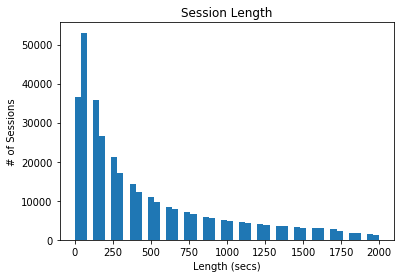

In [8]:
# What is the length of each session?

# calculate the duration of a session(session_end - session_start)
product_usage['session_duration_sec'] = (product_usage['session_end'] - product_usage['session_start']).dt.seconds

# calculate the average duration
average_length_per_session = product_usage['session_duration_sec'].median()
print(" The average length per session is " + str(average_length_per_session.round(decimals=2)) + " seconds")

plt.hist(product_usage['session_duration_sec'],range=[0,2000],bins=50)
plt.title('Session Length')
plt.xlabel('Length (secs)')
plt.ylabel('# of Sessions')

To calculate the average length of each session, we can examine every row in the visit dataframe and find the difference between the datetime of the end of a session and the datetime of the start of a session. 

The average length of each session is 300  seconds (5 mins). 

### How often do users come back?

15.59% of users on average come back weekly
3.91% of users on average come back monthly


Text(0, 0.5, '% of returning users')

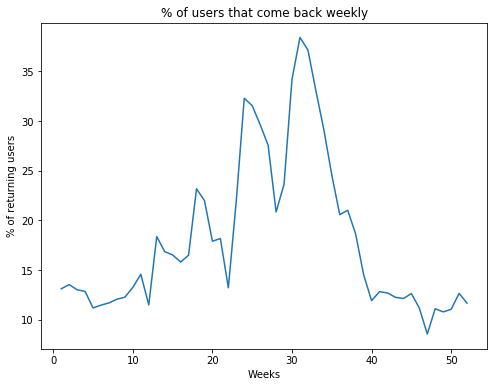

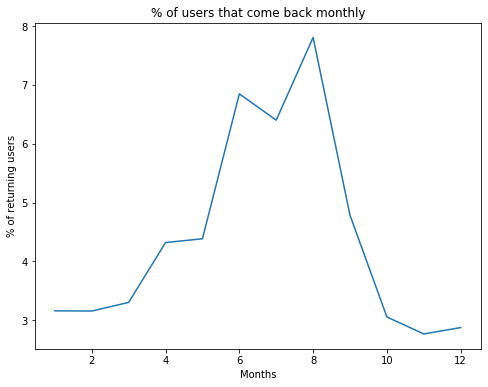

In [9]:
# How often do users come back?

# calculate sticky factor metrics
sticky_weekly_avg = (dau_avg / wau_avg) * 100
print(str(sticky_weekly_avg.round(decimals=2)) + "% of users on average come back weekly")

sticky_monthly_avg = (dau_avg / mau_avg) * 100
print(str(sticky_monthly_avg.round(decimals=2)) + "% of users on average come back monthly")

# graph sticky factor metrics 
wau_total['sticky_weekly'] = (dau_avg / wau_total['n_users']) * 100
plt.figure(figsize=(8,6))
plt.plot(wau_total['session_week'],wau_total['sticky_weekly'])
plt.title('% of users that come back weekly')
plt.xlabel('Weeks')
plt.ylabel('% of returning users')

mau_total['sticky_monthly'] = (dau_avg / mau_total['n_users']) * 100
plt.figure(figsize=(8,6))
plt.plot(mau_total['session_month'],mau_total['sticky_monthly'])
plt.title('% of users that come back monthly')
plt.xlabel('Months')
plt.ylabel('% of returning users')

To calculate how often users come back, we can calculate the stick factor metrics in terms of weeks and months. This is found by dividing the # of daily active users by the # of weekly active users (to find the number of times users come back weekly) and dividing the # of daily active users by the # of monthly active users (to find the number of times users come back monehtly).

Almost 16% of users come back weekly and 4% of users come back monthly. 

## Sales Evaluation for Yandex.Afisha

### When do people start buying?

In [10]:
# When do people start buying?

# for each user, find date of first order
first_order_dates = order_logs.groupby('user_id').agg({'order_datetime':'min'}).reset_index()
first_order_dates.columns= ['user_id','first_order_date']
first_order_dates['first_order_month'] = first_order_dates['first_order_date'].dt.month

# for each user, find date of first session
first_session_dates = visit_logs.groupby('user_id').agg({'session_start':'min'}).reset_index()
first_session_dates.columns= ['user_id','first_session_date']
first_session_dates['first_session_month'] = first_session_dates['first_session_date'].dt.month

# merge tables on user_id
turnover = pd.merge(first_session_dates, first_order_dates, on='user_id')

# calculate time between first session and first order
turnover['turnover_time_days'] = (turnover['first_order_date'] - turnover['first_session_date']).dt.days
display(turnover)

avg_turnover_time = turnover['turnover_time_days'].mean()
print('People start buying ' + str(avg_turnover_time.round(decimals=2)) +" days after first registering")

,user_id,first_session_date,first_session_month,first_order_date,first_order_month,turnover_time_days
0,313578113262317,2017-09-18 22:49:00,9,2018-01-03 21:51:00,1,106
1,1575281904278712,2017-06-03 10:13:00,6,2017-06-03 10:13:00,6,0
2,2429014661409475,2017-10-11 17:14:00,10,2017-10-11 18:33:00,10,0
3,2464366381792757,2018-01-27 20:10:00,1,2018-01-28 15:54:00,1,0
4,2551852515556206,2017-11-24 10:14:00,11,2017-11-24 10:14:00,11,0
...,...,...,...,...,...,...
36518,18445147675727495770,2017-08-20 13:30:00,8,2017-11-24 09:03:00,11,95
36519,18445407535914413204,2017-09-22 23:48:00,9,2017-09-22 23:55:00,9,0
36520,18445601152732270159,2017-08-07 11:51:00,8,2018-03-26 22:54:00,3,231
36521,18446156210226471712,2017-11-07 10:01:00,11,2018-02-18 19:34:00,2,103


People start buying 16.73 days after first registering


<div class="alert alert-danger">
<s><b>Needs fixing:</b> Please, check your calculations, most of the users start to buy during their first session.m
</div>

<div class="alert alert-info"> <b> i can't figure out what's going wrong in my calculations - i'm finding the first session date (assume that the minimum date in visits table is the date of registration/first visit)  and the first order date - then i'm subtracting the difference to see how many days is between the first session and the first order. what am i supposed ot be doing differently? </b></div>

<div class="alert alert-success">
<b>Success:</b> Sorry, my previous need fixing was based on damaged data, now it's okay.
</div>

In [11]:
# categorize cohorts by turnover time 
bins = [-2, 5, 10, 20, 30, 90, 180, 400]
labels = ['0-5d','5-10d','10-20d','20-30d','30-90d','90-180d','>180d']
turnover['turnover_cohort'] = pd.cut(x=turnover['turnover_time_days'], bins=bins, labels=labels)

To discover when people start buying, we can find the date of the first visit/session and first order for each user. By subtracting the date of the first visit from the date of the first order, we can find how long after the first visit the user made an order and purchased the product. We can find the average turnover time with the mean. 

The average turnover time for users from the first visit to the first order for Yandex.Afisha is about 16 days. 

In [12]:
# how many users in each cohort
users_per_cohort = turnover.groupby('turnover_cohort')['user_id'].nunique().reset_index()
users_per_cohort.columns = ['turnover_cohort','n_users']

# calculate % of users in each cohort
total_users = users_per_cohort['n_users'].sum()
users_per_cohort['users %'] = (users_per_cohort['n_users'] / total_users) * 100

display(users_per_cohort)

,turnover_cohort,n_users,users %
0,0-5d,28965,79.306191
1,5-10d,947,2.592887
2,10-20d,1039,2.844783
3,20-30d,670,1.834460
4,30-90d,2274,6.226214
5,90-180d,1748,4.786025
6,>180d,880,2.409441


Most users start buying between 0 to 5 days after the first session at almost 80% of users but thereafter, the largest turnover cohort falls in the 3-6 month window at 6% of users. 

<div class="alert alert-warning">
<b>Remarks: </b> You can split your data in groups more easily and faster. Check this link:<br> <a>https://stackoverflow.com/questions/43500894/pandas-pd-cut-binning-datetime-column-series</a> <br>
The difference in apply() and cut() method becomes crucial in large datasets and could be an hour or more.<br>
    
Please, don't mix functions with the other code in one cell.
 

</div>

<div class="alert alert-success">
<b>Success:</b> Great that you master it! 🤘
</div>

<div class="alert alert-danger">
<s><b>Needs fixing:</b> Please, check your calculations, turnover_time_days can't be negative.
</div>

<div class="alert alert-info"> <b> Hi! The project instructor Anastasia said that turnover times of -1 days was okay but if yo say they aren't, does that mean I should cut them out? to calculate turnover, i'm subtracting the dqate of the first order from the date of the first session </b></div>

<div class="alert alert-warning">
<b>Remarks: </b> Ok, let it be okay. 
</div>

### How many orders do they make during a given period of time?

In [13]:
# How many orders do they make during a given period of time? 

# extract order month for each order
order_logs['order_month'] = order_logs['order_datetime'].astype('datetime64[M]').dt.month

# group by order month and find # of unique users placing orders each month and find # of orders made each month
unique_orders = order_logs.groupby('order_month').agg({'user_id':'nunique','order_datetime':'count'}).reset_index()
unique_orders.columns = ['order_month','n_unique_users','n_orders']

# create col with average monthly orders per month
unique_orders['average_monthly_orders'] = unique_orders['n_orders'] / unique_orders['n_unique_users']

# calculate average monthly purchases
avg_monthly_purchases = unique_orders['average_monthly_orders'].mean().round(decimals=2)

print('The average number of orders made in any given month is ' + str(avg_monthly_purchases))

The average number of orders made in any given month is 1.22


<div class="alert alert-warning">
<b>Remarks: </b> It should be a little less, but in general you are right. I think this value will fix automatically after you tun off your cleaning filters.
</div>

<div class="alert alert-success">
<b>Success:</b> Correct
</div>

To find how many orders do users make during a period of time, we can start by defining a period of time as a single month. Now the question becomes how many orders do users make during a months time? We can extract the month of each order from the datetime of the order, group the orders by the months, count the # of unique users ordering for each month, count the # of orders made each month and then find the average number of monthly orders by diving the # of orders with the # of unique users. 

The average number of orders made during a month for Yandex.Afisha is 1.22 orders.

### What is the average purchase size?

In [14]:
# What is the average purchase size?

avg_purchase_size = order_logs['revenue'].mean().round(decimals=2)
print("The average purchase size is " + str(avg_purchase_size) + " dollars per purchase")

The average purchase size is 5.0 dollars per purchase


To find the average purchase size for each order, we can calculate the average of the revenue made from each order. 

The average purchase size for Yandex.Afisha is about $5 per purchase. 

<div class="alert alert-success">
<b>Success:</b> Correct
</div>

### How much money do they bring? (LTV)

In [15]:
# How much money do they bring? (LTV)
# LTV (lifetime value) is the total amount of money a customer brings to the company on average by making purchases

# # copy dataframes
orders = order_logs.copy()
visit = visit_logs.copy()
visit = visit[['session_start','user_id']]

# extract month and date for each datetime row 
orders['order_month'] = orders['order_datetime'].astype('datetime64[M]')
orders['order_date'] = orders['order_datetime'].dt.date

# Calculate when first order for each customer have happened

visits_and_orders = orders.join(visit
                      .sort_values(by='session_start')
                      .groupby(['user_id'])
                      .agg({'session_start': 'min'}),
                      on='user_id', how='inner')

visits_and_orders['first_session_month'] = visits_and_orders['session_start'].astype('datetime64[M]')

# Create cohorts based on first purchase date and revenue

cohort_sizes = visits_and_orders.groupby('first_session_month').agg({'user_id': 'nunique'}).reset_index()
cohort_sizes.rename(columns={'user_id': 'n_buyers'}, inplace=True)

cohorts = visits_and_orders.groupby(['first_session_month', 'order_month']).agg({'revenue': ['sum', 'count']}).reset_index()

# Calculate cohort age

cohorts['age_month'] = (cohorts['order_month'] - cohorts['first_session_month']) / np.timedelta64(1, 'M')
cohorts['age_month'] = cohorts['age_month'].round().astype('int')
cohorts.columns = ['first_session_month', 'order_month', 'revenue', 'n_orders', 'age_month']

# Merge our cohort tables to the final cohort report
report = pd.merge(cohort_sizes, cohorts, on='first_session_month')
report['ltv'] = cohort_report['revenue'] / cohort_report['n_buyers']

# Create LTV table
ltv_cohort = report.pivot_table(
    index = 'first_session_month',
    columns = 'age_month',
    values = 'ltv',
    aggfunc = 'sum').cumsum(axis=1)

plt.figure(figsize=(15, 5))
sns.heatmap(ltv_cohort, annot=True, fmt='.2f');

NameError: name 'cohort_report' is not defined

LTV (lifetime value) is the total amount of money a customer brings to the company on average by making purchases. To calcuate this metric, I extracted the first order month and all months afterwards and grouped this data per user while adding up the revenue. I found the gross profit for each cohort and then calculated LTV from that. The heatmap indicates that the most revenue is always from the first order month and afterwards, the trend tends to decrease so the customer does not bring the company much money after it's initial purchase. 

For the most part, the lifetime value per customer increases over time.

<div class="alert alert-warning">
<b>Remarks: </b> Yeah, sure. Please, check your groupby and merge approaches. <br>
Hint: Cohort graphics looks like triangle. You should see something like that: <a>http://seaborn.pydata.org/_images/seaborn-heatmap-12.png<a> 
 
</div>

<div class="alert alert-danger">
<s><b>Needs fixing:</b> Your calculations are correct, but not sufficient. Please, provide more detailed analyis with <b>user cohorts</b> and plot heatmap.
 
</div>


<div class="alert alert-info"> <b> I don't understand what I'm doing wrong - i have cohort on tha y axis and the months on the xaxis. this is how they showed us on the practicum  </b></div>

<div class="alert alert-warning">
<b>Remarks: </b> Now it looks much better! LTV values in the heatmap should be a float, like in the report table.
You have an excessive round() operation in your pivot chain.
 
</div>

<div class="alert alert-info"> <b> hi!! so finally happy that i got it. thank you for your patience :) </b></div>

<div class="alert alert-danger">
<s><b>Needs fixing:</b> Sorry, but we have to come back to this block. I'm very sorry that I didn't find the depth of the original error and could not give you the necessary instructions initially.<br>
Let's calculate LTV step by step with me.  

</div>

<div class="alert alert-danger">
<s><b>Needs fixing:</b> You were quite close to the solution, the problem was in the first part of your ltv pipeline.
Again - sorry that I didn't find better option that to show you code sample. Now you can adapt it for your solution.
    
</div>

<div class="alert alert-success">
<b>Success:</b> Well, I hoped that you would prefer to adapt those code, not to copy-paste it. Anyway, now it's correct.
</div>

## Marketing Evaluation for Yandex.Afisha

<div class="alert alert-danger">
<s><b>Needs fixing:</b> Again, your calculations in marketing block are correct, but not sufficient. Please, provide more detailed analyis with <b>user cohorts</b> and plot heatmap.
 
</div>

### How much money was spent? Overall/per source/over time

<div class="alert alert-info"> <b>look better?</b></div>

<div class="alert alert-warning">
<b>Remark:</b> LTV - yes, definately. If you ask about marketing evaluation - please, check your CAC calcuation.
</div>

In [ ]:
# How much money was spent? 

# Overall
cost_overall = cost['ad_expenses'].sum()
print('The overall amount spent on marketing was $' + str(cost_overall))

<div class="alert alert-success">
<b>Success:</b> Correct
</div>

In [ ]:
# per source
cost_per_source = cost.groupby('source_id').agg({'ad_expenses':'sum'}).reset_index()
cost_per_source.columns = ['source_id','total_ad_expenses']

plt.figure(figsize=(8,6))
plt.bar(cost_per_source['source_id'],cost_per_source['total_ad_expenses'])
plt.title('Ad Costs Per Source')
plt.xlabel('Source')
plt.ylabel('Amount Spent ($)')

<div class="alert alert-success">
<b>Success:</b> Correct
</div>

In [ ]:
# Over time
cost_over_time = cost.copy()
cost_over_time['ad_month'] = cost['ad_datetime'].astype('datetime64[M]').dt.month
cost_over_time = cost_over_time.groupby('ad_month').agg({'ad_expenses':'sum'}).reset_index()
cost_over_time.columns = ['ad_month','ad_expenses']

plt.figure(figsize=(8,6))
plt.plot(cost_over_time['ad_month'],cost_over_time['ad_expenses'])
plt.title('Ad Costs Over Time')
plt.xlabel('Months')
plt.ylabel('Amount Spent ($)')

<div class="alert alert-success">
<b>Success:</b> Correct
</div>

### How much did customer acquisition from each of the sources cost?

<div class="alert alert-warning">
<b>Remarks: </b> Now, with update cohort report you will give more adequate results.
</div>

In [ ]:
# How much did customer acquisition from each of the sources cost?

# CAC
# calculate ad expenses per month
monthly_ad_cost = cost.copy()
monthly_ad_cost['ad_month'] = monthly_ad_cost['ad_datetime'].dt.month
monthly_ad_cost = monthly_ad_cost[['ad_month','ad_expenses']]
monthly_ad_cost = monthly_ad_cost.groupby('ad_month')['ad_expenses'].sum().reset_index()

# incorpordate data on costs
report['order_month'] = report['order_month'].dt.month

report = pd.merge(report, monthly_ad_cost, left_on='order_month', right_on='ad_month')

# calculate cac
report['cac'] = report['ad_expenses'] / report['n_buyers']

# starting at first order month and continuing through order months,what is cac per cohort
result = report.pivot_table(index='order_month',columns='ad_month',values='cac',aggfunc='mean').round()
result.fillna('')

plt.figure(figsize=(13,9))
plt.title('CAC per Cohort')
sns.heatmap(result, annot=True, fmt='.1f', linewidths=1, linecolor='black')

CAC (customer acquisition cost) is the cost of attracting a customer - how much was spent in marketing efforts to acquire a single customer. To calculate this, we can compare the amount spent on ads for the same month that the customer made a purchase by dividing expenses spent on ads by the number of buyers for each month. 

<div class="alert alert-success">
<s><b>Success:</b> Right
       
</div>

<div class="alert alert-danger">
<s><b>Need to fix:</b> Oh, something strange is happening here. Please, check your code, Agathe.
</div>

### How worthwhile where the investments? (ROI)

In [ ]:
# How worthwhile where the investments? (ROI)

# calculate return on marketing investment 
report['romi'] = report['ltv'] / report['cac']

output = report.pivot_table(index='order_month', columns='ad_month',values='romi',aggfunc='mean')
output = output.cumsum(axis=1).round(2)

plt.figure(figsize=(13,9))
plt.title('ROI per Cohort')
sns.heatmap(output, annot=True, fmt='.1f', linewidths=1, linecolor='black')

<div class="alert alert-success">
<b>Success:</b> Correct
</div>

## Conclusion

Advise marketing experts how much money to invest and where:

From my investigation, I would advise marketing experts at Yandex.Afisha to invest in ad source number 3 as it brings in the most customers. However, it is clear from the data that the LTV (lifetime customer value) is significantly less than the CAC (customer acquisition cost) which is a sign that Yandex.Afisha is not doing  well. On average, the LTV per cohort (defined as first purchase month) is $0.51 and the CAC per cohort  is $8.90. This means that for every $8.90 spent on acquiring customers, the customer only made $0.51 in profit. This can be seen overall where total ad expenses is $329,131 while total revenue is $252,057. 

Since Yandex.Afisha is losing money, I would recommend that they increase the cost of products, decrease marketing costs or invest marketing costs more intelligently. 